In [1]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.metrics import accuracy_score 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [145]:

# df = pd.read_csv("merged_dataset.csv", engine="python", sep=",")
# X = df.drop(columns=["Is.Fraudulent"]).copy()
# y = df["Is.Fraudulent"].copy()

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# ValidationData = pd.concat([X_val, y_val], axis=1)  
# ValidationData.to_csv("ValidationData.csv", index=False)

# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

# y_test = pd.DataFrame(y_test, columns=["Is.Fraudulent"])
# y_train = pd.DataFrame(y_train, columns=["Is.Fraudulent"])


# TestData = pd.concat([X_test, y_test], axis=1)  
# TestData.to_csv("TestData.csv", index=False)

# TrainData = pd.concat([X_train, y_train], axis=1)  
# TrainData.to_csv("TrainData.csv", index=False)


In [2]:
class TimeTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self  
    def transform(self, X):
        df = X.copy()  
        if "Transaction.Date" not in df.columns: 
            raise ValueError("What are you doing man?")
        df["Transaction.Date"] = pd.to_datetime(df["Transaction.Date"], format = "ISO8601")
    
                
        df["day"] = df["Transaction.Date"].dt.day.astype(float)

            
        df["month"] = df["Transaction.Date"].dt.month.astype(float)
        df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
        df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
        df["month_angle"]=np.arctan2(df["month_sin"],df["month_cos"]) 
        
        if "Transaction.Hour" in df.columns:
            df["hour_sin"] = np.sin(2 * np.pi * df["Transaction.Hour"] / 24)
            df["hour_cos"] = np.cos(2 * np.pi * df["Transaction.Hour"] / 24)
            df["hour_angle"] = np.arctan2(df["hour_sin"], df["hour_cos"])
        else:
            raise ValueError("What are you doing man?")
        
        df["Transaction.Weekday"] = df["Transaction.Date"].dt.weekday + 1
        df["FirstPartMonth"]=df["day"].apply(lambda x: 1 if x<=12 else 0) 
            
        weekDaysEncoded=pd.get_dummies(df["Transaction.Weekday"]) 
        
        result=pd.concat([df[["month_angle", "hour_angle","FirstPartMonth"]], weekDaysEncoded], axis=1)
        
        return result.to_numpy()
    

In [7]:
class AgeTransfomer(BaseEstimator, TransformerMixin): 

    def __init__(self): 
        pass   
    def fit(self, X, y=None):
        return self  
    def transform(self, X):
        df=X.copy() 
        if "Customer.Age" not in df.columns: 
            raise ValueError("What are you doing man?")
        df["Is.Minor"]=df["Customer.Age"].apply(lambda x : True if x<18 else False) 
        df["Is.Senior"]=df["Customer.Age"].apply(lambda x : True if x>60 else False) 
        return pd.concat([df[["Is.Minor"]], df[["Is.Senior"]]], axis = 1).to_numpy()
        

In [4]:
class SexTransformer(BaseEstimator, TransformerMixin): 
    def __init__(self): 
         pass    
    def fit(self, X, y=None):
        return self  
    def transform(self, X):
        df=X.copy() 
        if "sex" not in df.columns: 
            raise ValueError("What are you doing man?")
        df["male"]=df["sex"].apply(lambda x : True if x=="M" else False)
        return df[["male"]].to_numpy() 
    

In [5]:
class BinaryPassthroughTransformer(BaseEstimator, TransformerMixin): 
    def __init__(self): 
        pass   
    def fit(self, X, y=None):
        return self  
    def transform(self, X):
        df=X.copy() 
        return df.to_numpy() 

In [6]:
df = df=pd.read_csv("TrainData.csv")
X = df.drop(columns=["Is.Fraudulent"]).copy()
y = df["Is.Fraudulent"].copy()
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

## FIRST MODELS

In [8]:
def PipelineModel(model,Numerical=['Transaction.Amount', 'Customer.Age','Account.Age.Days','Quantity'],
                    CatBasic=["Payment.Method",'browser','Product.Category','Device.Used','source','Address.Match']):
    
    
    column_transformer = ColumnTransformer([
    ('time_features', TimeTransformer(),["Transaction.Date","Transaction.Hour"]), 
    ("numerical",StandardScaler(),Numerical), 
    ("age",AgeTransfomer(),["Customer.Age"]),
    ("sex",SexTransformer(),["sex"]),
    ("AddressMatch",BinaryPassthroughTransformer(),["Address.Match"]),
    ("catBasic", OneHotEncoder(drop='if_binary' , handle_unknown='ignore'),CatBasic)])

    classifier_pipeline=Pipeline([
    ('preprocessor', column_transformer),  
    ('smote', SMOTE(sampling_strategy=0.1,random_state=42)) ,
    ('model',model)
     ])
    return classifier_pipeline

    
def PredictionQualityInfo(y_pred,y_test):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    print("Classification Report:\n", classification_report(y_test, y_pred))

    
def FitPredictResult(model,X_train,X_test,y_train,y_test):
    classifier=PipelineModel(model)
    classifier.fit(X_train,y_train) 
    y_pred=classifier.predict(X_test) 
    PredictionQualityInfo(y_pred,y_test) 

<img src=attachment:892de149-cf77-453a-bd39-4827cf469b82.png width="600" height="600">

RandomForestClassifier:


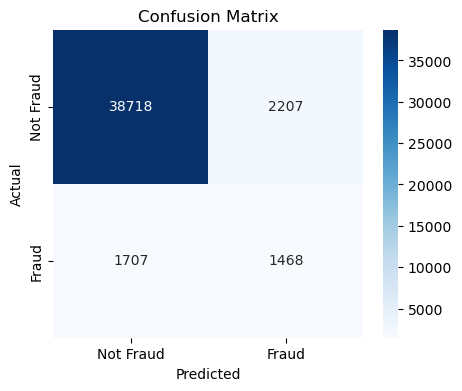

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95     40925
           1       0.40      0.46      0.43      3175

    accuracy                           0.91     44100
   macro avg       0.68      0.70      0.69     44100
weighted avg       0.92      0.91      0.91     44100




LogisticRegression:


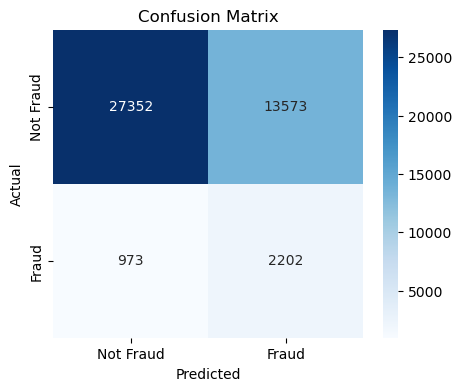

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.67      0.79     40925
           1       0.14      0.69      0.23      3175

    accuracy                           0.67     44100
   macro avg       0.55      0.68      0.51     44100
weighted avg       0.91      0.67      0.75     44100




KNeighborsClassifier:


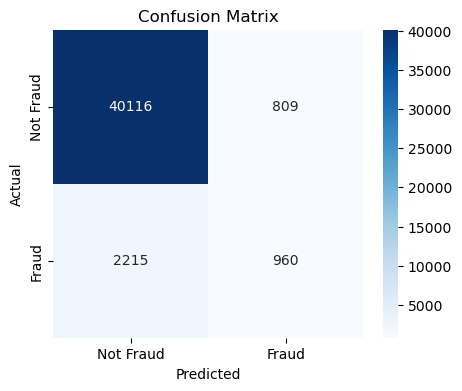

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96     40925
           1       0.54      0.30      0.39      3175

    accuracy                           0.93     44100
   macro avg       0.75      0.64      0.68     44100
weighted avg       0.92      0.93      0.92     44100






In [13]:
Models=[RandomForestClassifier(n_estimators=100,bootstrap=True,max_features="sqrt",random_state=42,max_depth=4,class_weight="balanced"),LogisticRegression(random_state=42,class_weight="balanced"), 
       KNeighborsClassifier(n_neighbors=5, metric='euclidean')]

for i in Models: 
    print(i.__class__.__name__, ":", sep="")
    FitPredictResult(i,X_train,X_test,y_train,y_test)
    print("\n\n")